# Subclassing API

{{ badge }}

Using the Subclassing API to Build Dynamic Models
Both the Sequential API and the Functional API are declarative: you start by declaring which layers you want to use and how they should be connected, and only then can you start feeding the model some data for training or inference.

This has many advantages: 

1.   the model can easily be saved.
2.   can easily be cloned.
3.   can easily be shared.
4.   the model structure can be displayed and analyzed.
5.   the framework can infer shapes and check types, so errors can be caught early (i.e., before any data ever goes through the model).
6.   It’s also fairly easy to debug.
 

since the whole model is a static graph of layers. But the flip side is just that: it’s static. 

Some models involve loops, varying shapes, conditional branching,
and other dynamic behaviors. For such cases, or simply if you prefer a more imperative programming style, the Subclassing API is for you.

Simply subclass the Model class, create the layers you need in the constructor, and use them to perform the computations you want in the call() method. 

For example, creating an instance of the following WideAndDeepModel class gives us an equivalent model to the one we just built with the Functional API. 

You can then compile it, evaluate it, and use it to make predictions, exactly like we just did:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### MNIST Example

The MNIST database is a large database of handwritten digits that is commonly used for training various image processing systems. This database it built-into TensorFlow, we can load it from the `tf.keras.datasets` module.

This function returns two tuples, one for the training set and one for the testing set. The dataset has 60,000 example for training and 10,000 for testing.

Load and prepare the MNIST dataset. Convert the samples from integers to floating-point numbers:



shape of x_train: (60000, 28, 28)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0 

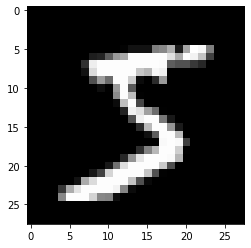

In [ ]:
# load mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("shape of x_train:", x_train.shape)
print(x_train[0])
print("the label of x_train[0] is :", y_train[0])
# show an image
plt.imshow(x_train[0], cmap="gray")

#### One Hot Encoding

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

Instead of the target being a singular value (i.e. 3), it becomes a vector that's size is equal to the number of unique targets in the dataset, with all values being 0 except for one which would represent the original singluar value.

In case of having 5 different targets, the one-hot vector will be of length 5, look at the table below to see how the original values are represented as one hot encoded vectors

| Before One Hot Encoding | After One Hot Encoding |
|-------------------------|------------------------|
| 0                       | [1, 0, 0, 0, 0]        |
| 1                       | [0, 1, 0, 0, 0]        |
| 2                       | [0, 0, 1, 0, 0]        |
| 3                       | [0, 0, 0, 1, 0]        |
| 4                       | [0, 0, 0, 0, 1]        |


We can one-hot encode the targets using `tf.one_hot` method, let's do that for the MNIST dataset target

shape of x_train: (60000, 784)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.

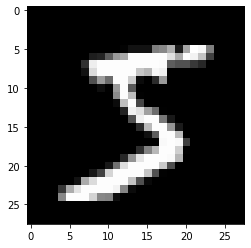

In [ ]:
# reshape the data
x_train, x_test = x_train.reshape(-1, 28 * 28), x_test.reshape(-1, 28 * 28)
# normalize the pixel values so that each pixel value has a value between 0 and 1.
x_train, x_test = x_train / 255, x_test / 255
# convert the labels to one-hot vector for y_train and y_test, using one-hot encodeing
y_train, y_test = tf.one_hot(y_train, 10), tf.one_hot(y_test, 10)
print("shape of x_train:", x_train.shape)
print(x_train[0])
print(
    "the label of x_train[0] is :",
    y_train[0],
    "\n the argmax of y_train[0] :",
    tf.argmax(y_train[0]),
)
# show an image
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")

In [ ]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, input_shape, units=30, activation="relu", **kwargs):
        super(WideAndDeepModel, self).__init__(
            **kwargs
        )  # handles standard args (e.g., name)

        self.input_layer = tf.keras.layers.Input(input_shape)
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    # AFAIK: The most convenient method to plot the model
    # similar to the sequential or functional API like.
    def build_graph(
        self,
    ):
        x = self.input_layer
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

    def call(self, inputs):

        hidden1 = self.hidden1(inputs)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([hidden2, inputs])
        output = self.out(concat)

        return output


model = WideAndDeepModel(input_shape=(784))
model.build(input_shape=(None, 784))  # build the model

model.summary()

Model: "wide_and_deep_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            multiple                  23550     
                                                                 
 dense_20 (Dense)            multiple                  930       
                                                                 
 dense_21 (Dense)            multiple                  8150      
                                                                 
Total params: 32,630
Trainable params: 32,630
Non-trainable params: 0
_________________________________________________________________


This example looks very much like the Functional API, except we do not need to create the inputs; we just use the input argument to the `call()` method, and we separate
the creation of the layers in the constructor from their usage in the `call()` method.
The big difference is that you can do pretty much anything you want in the `call()`
method: for loops, if statements, low-level TensorFlow operations your imagination is the limit ! This makes it a great API for researchers experimenting with new ideas.

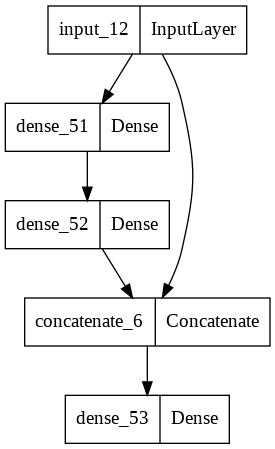

In [ ]:
tf.keras.utils.plot_model(model.build_graph())

### Train The Model 

In [ ]:
# compile the model an using adam optimizer with Categorical crossentropy cost function
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=[tf.metrics.CategoricalAccuracy()],
)
# train the model with batch_size=32,for 10 epochs
model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.3604 - categorical_accuracy: 0.8980 - val_loss: 0.1772 - val_categorical_accuracy: 0.9482
Epoch 2/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.1852 - categorical_accuracy: 0.9461 - val_loss: 0.1298 - val_categorical_accuracy: 0.9647
Epoch 3/10
1688/1688 [==============================] - 8s 4ms/step - loss: 0.1383 - categorical_accuracy: 0.9589 - val_loss: 0.1066 - val_categorical_accuracy: 0.9698
Epoch 4/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.1103 - categorical_accuracy: 0.9662 - val_loss: 0.1175 - val_categorical_accuracy: 0.9687
Epoch 5/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0918 - categorical_accuracy: 0.9720 - val_loss: 0.1065 - val_categorical_accuracy: 0.9687
Epoch 6/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0790 - categorical_accuracy: 0.9755 - val_loss: 0.0933 - val_categorical_accuracy:

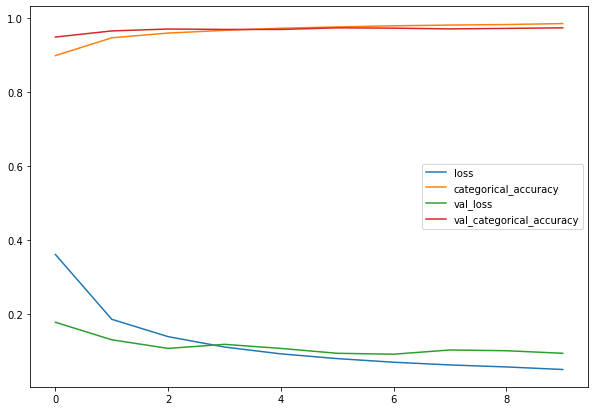

In [ ]:
train_hist_df = pd.DataFrame(model.history.history)
train_hist_df.plot(figsize=(10, 7))

# Custom Layers
You may occasionally want to build an architecture that contains an exotic layer for which TensorFlow does not provide a default implementation. In this case, you will
need to create a custom layer.

 Or you may simply want to build a very repetitive
architecture, containing identical blocks of layers repeated many times, and it would
be convenient to treat each block of layers as a single layer. For example, if the model
is a sequence of layers A, B, C, A, B, C, A, B, C, then you might want to define a custom layer D containing layers A, B, C, so your model would then simply be D, D, D.
Let’s see how to build custom layers.

First, some layers have no weights, such as tf.keras.layers.Flatten or tf.keras.layers.ReLU. 

If you want to create a custom layer without any weights, the simplest
option is to write a function and wrap it in a tf.keras.layers.Lambda layer. 

For example, the following layer will apply the exponential function to its inputs:

`exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))`

This custom layer can then be used like any other layer, using the Sequential API, the
Functional API, or the Subclassing API. You can also use it as an activation function
(or you could use activation=tf.exp, activation=tf.keras.activations.exponential, or simply activation="exponential"). The exponential layer is sometimes used in the output layer of a regression model when the values to predict have very
different scales (e.g., 0.001, 10., 1,000.).
As you’ve probably guessed by now, to build a custom stateful layer (i.e., a layer withweights), you need to create a subclass of the keras.layers.Layer class. For example, the following class implements a simplified version of the Dense layer:

In [ ]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units  # the units in the Dense layer
        self.activation = tf.keras.activations.get(
            activation
        )  # get the actviton function

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal",
        )
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros"
        )
        super().build(batch_input_shape)  # must be at the end

    def call(self, X):
        return self.activation(tf.matmul(X, self.kernel) + self.bias)


layer = MyDense(10)

Let’s walk through this code:

• The constructor takes all the hyperparameters as arguments (in this example,units and activation), and importantly it also takes a **kwargs argument.
It calls the parent constructor, passing it the kwargs: this takes care of standard arguments such as input_shape, trainable, and name. Then it saves the hyperparameters as attributes, converting the activation argument to the appropriate
activation function using the tf.keras.activations.get() function (it accepts
functions, standard strings like "relu" or "selu", or simply None).

• The build() method’s role is to create the layer’s variables by calling the
add_weight() method for each weight. 
The build() method is called the first
time the layer is used. 
At that point, TensorFlow will know the shape of this layer’s
inputs, and it will pass it to the build() method,9 which is often necessary to cre‐
ate some of the weights. For example, we need to know the number of neurons in
the previous layer in order to create the connection weights matrix (i.e., the
"kernel"): this corresponds to the size of the last dimension of the inputs. At the
end of the build() method (and only at the end), you must call the parent’s

build() method: this tells TensorFlow that the layer is built (it just sets
self.built=True).

• The call() method performs the desired operations. In this case, we compute
the matrix multiplication of the inputs X and the layer’s kernel, we add the bias
vector, and we apply the activation function to the result, and this gives us the
output of the layer.

# Bulid custom model with custom layer

We already looked at creating custom model classes , when we discussed the Subclassing API. It’s straightforward: subclass the tf.keras.Model class, create layers and variables in the constructor, and implement the call() method to do whatever you want the model to do.

now we will implement the wide and deep model using Subclassing api from tensorflow .


• First, we need to create  the block class for the model we will call it WideLayerBlock and the class will get the input with hidden units of the layers.

• Next, inside the WideLayerBlock calss  we create a Dense layer , using the ReLU activation function. As soon as it is created, notice that we call it like a function, passing it the
x. This is why this is called the Subclassing API. Note that we are just telling
tensorflow  how it should connect the layers together; no actual data is being processed yet.

• We then create a second hidden layer, and again we use it as a function. Note that we pass it the output of the first hidden layer.

• Next, we create a Concatenate layer, and once again we immediately use it like a
function, to concatenate the input and the output of the second hidden layer. You may prefer the `tf.keras.layers.concatenate()` function, which creates a
Concatenate layer and immediately calls it with the given inputs.

*than we return the output of block 


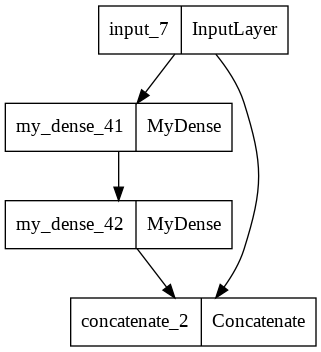

In [ ]:
class WideLayerBlock(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(
            units, activation=activation
        )  # using our custom dense layer
        self.hidden2 = MyDense(units, activation=activation)

    # AFAIK: The most convenient method to plot the model
    # similar to the sequential or functional API like.
    def build_graph(
        self,
    ):
        x = tf.keras.layers.Input(10)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

    def call(self, X):
        hidden1 = self.hidden1(X)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([hidden2, X])
        return concat


tf.keras.utils.plot_model(
    WideLayerBlock(512).build_graph()
)  # plot the layer uisng plot model from tensorflow

## Create The Model 

In [ ]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, input_shape, activation="relu", **kwargs):
        super(WideAndDeepModel, self).__init__(
            **kwargs
        )  # handles standard args (e.g., name)

        self.input_layer = tf.keras.layers.Input(input_shape)
        self.block_1 = WideLayerBlock(units=256, activation=activation)
        self.block_2 = WideLayerBlock(units=182, activation=activation)
        self.out = MyDense(10, activation=tf.nn.softmax)

    # AFAIK: The most convenient method to plot the model
    # similar to the sequential or functional API like.
    def build_graph(
        self,
    ):
        x = self.input_layer
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

    def call(self, inputs):

        block_1 = self.block_1(inputs)
        block_2 = self.block_2(block_1)
        output = self.out(block_2)

        return output


model = WideAndDeepModel(input_shape=(784))
model.build(input_shape=(None, 784))  # build the model

model.summary()

Model: "wide_and_deep_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wide_layer_block_18 (WideLa  multiple                 266752    
 yerBlock)                                                       
                                                                 
 wide_layer_block_19 (WideLa  multiple                 222768    
 yerBlock)                                                       
                                                                 
 my_dense_52 (MyDense)       multiple                  12230     
                                                                 
Total params: 501,750
Trainable params: 501,750
Non-trainable params: 0
_________________________________________________________________


• First, we need to create an Input object. This is a specification of the kind of input the model will get, including its shape and dtype. A model may actually
have multiple inputs, as we will see shortly.

• Next, we create a block with 256 neurons,. As soon as it is created, notice that we call it like a function, passing it the
input. This is why this is called the Functional API. Note that we are just telling
tensorflow  how it should connect the layers together; no actual data is being processed yet.

• We then create a second block, and again we use it as a function. Note that we pass it the output of the first block.




• Then we create the output layer, with a 10 neuron's and softmax as  activation function.


• Lastly, we create a tensorflow Model, specifying which inputs and outputs to use.


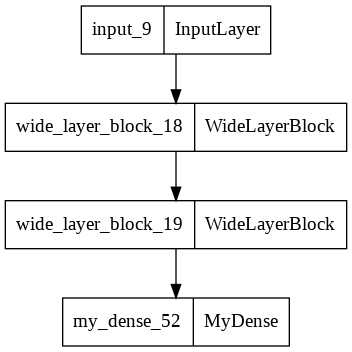

In [ ]:
tf.keras.utils.plot_model(model.build_graph())

## Train The Model 

In [ ]:
# compile the model an using adam optimizer with Categorical crossentropy cost function
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=[tf.metrics.CategoricalAccuracy()],
)
# train the model with batch_size=32,for 10 epochs
model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2042 - categorical_accuracy: 0.9373 - val_loss: 0.0913 - val_categorical_accuracy: 0.9705
Epoch 2/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.0870 - categorical_accuracy: 0.9729 - val_loss: 0.0855 - val_categorical_accuracy: 0.9745
Epoch 3/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0612 - categorical_accuracy: 0.9799 - val_loss: 0.0764 - val_categorical_accuracy: 0.9773
Epoch 4/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.0444 - categorical_accuracy: 0.9860 - val_loss: 0.0731 - val_categorical_accuracy: 0.9798
Epoch 5/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.0376 - categorical_accuracy: 0.9879 - val_loss: 0.0872 - val_categorical_accuracy: 0.9762
Epoch 6/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.0287 - categorical_accuracy: 0.9906 - val_loss: 0.1201 - val_categorical_acc

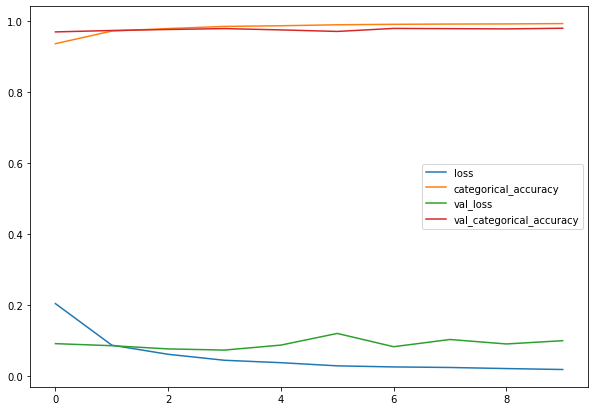

In [ ]:
train_hist_df = pd.DataFrame(model.history.history)
train_hist_df.plot(figsize=(10, 7))  # plot the model train history

# Subclassing API to Build ResNet
Kaiming He et al. won the ILSVRC 2015 challenge using a Residual Network (orResNet),
that delivered an astounding top-five error rate under 3.6%. The winning
variant used an extremely deep CNN composed of 152 layers (other variants had 34,50, and 101 layers). 

It confirmed the general trend: models are getting deeper and
deeper, with fewer and fewer parameters. 

The key to being able to train such a deep network is to use skip connections (also called shortcut connections): the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack. Let’s see why this is useful.

When training a neural network, the goal is to make it model a target function h(x).

If you add the input x to the output of the network (i.e., you add a skip connection),then the network will be forced to model f(x) = h(x) – x rather than h(x). 

This is called **residual learning**



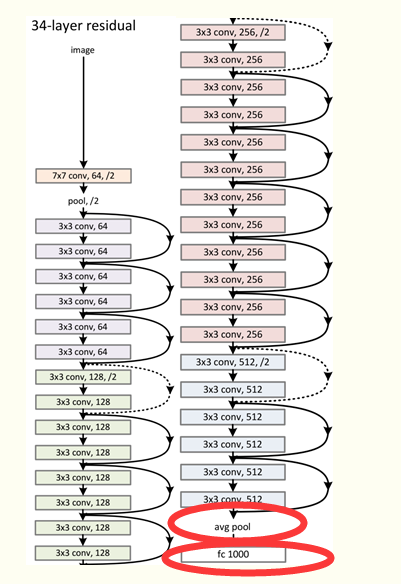

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

170498071/170498071 [==============================] - 157s 1us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

The targets' shape is (50000, 1) and (10000, 1), 50000 and 10000 refer to the number of samples in the training and testing set respectively, while the 1 means that the value of each sample is an array with a single value, to prepare the data to be one-hot encoded, we will remove the array and keep only the integer value

In [3]:
print("Target values before reshaping: ", y_train[0], y_test[0])

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

print("Target values after reshaping: ", y_train[0], y_test[0])

x_train.shape, y_train.shape, x_test.shape, y_test.shape

Target values before reshaping:  [6] [3]
Target values after reshaping:  6 3


((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

In [4]:
# Normalize pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert the labels to one hot vectors
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)

y_train[0], tf.argmax(y_train[0])

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6>)

To verify that the dataset is loaded correctly, let's plot the first 25 images from the training set and display the class name under each image.

The description (i.e. `class_name`) is taken from CIFAR10's documentation here: https://www.cs.toronto.edu/~kriz/cifar.html


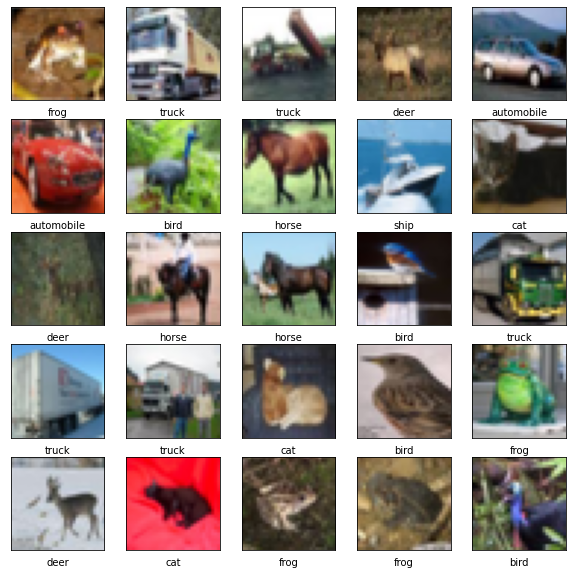

In [5]:
# The ordering of the labels corresponds to the target
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(10, 10))  # Set the size of the plot

for i in range(25):

    plt.subplot(5, 5, i + 1)  # Create a subplot on a 5x5 grid for index i

    plt.xticks([])  # Remove the ticks of the number line from the x axis
    plt.yticks([])  # Remove the ticks of the number line from the y axis

    plt.imshow(
        x_train[i]
    )  # Plot the image, no need to use the cmap parameter since this image is in RGB

    target_index = tf.argmax(
        y_train[i]
    )  # Convert the one-hot encoding to the original value
    plt.xlabel(class_names[target_index])  # Add the class name below the image

## a) Identical residual block
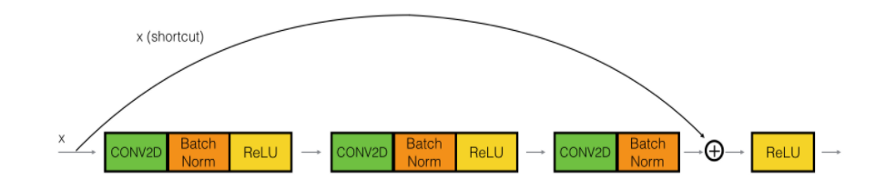

When you initialize a regular neural network, its weights are close to zero, so the network just outputs values close to zero.

 If you add a skip connection, the resulting network just outputs a copy of its inputs; in other words, it initially models the identity
function. 

If the target function is fairly close to the identity function (which is often the case), this will speed up training considerably.


In [6]:
tf.keras.backend.clear_session()

In [7]:
class IdenticalBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        f1, f2 = filters
        super(IdenticalBlock, self).__init__()
        # layer 1
        self.Conv1 = tf.keras.layers.Conv2D(
            filters=f1, kernel_size=(1, 1), use_bias=False, padding="valid"
        )
        self.BN1 = tf.keras.layers.BatchNormalization()
        # layer 2
        self.Conv2 = tf.keras.layers.Conv2D(
            filters=f1, kernel_size=(3, 3), use_bias=False, padding="same"
        )
        self.BN2 = tf.keras.layers.BatchNormalization()
        # layer 3
        self.Conv3 = tf.keras.layers.Conv2D(
            filters=f2, kernel_size=(1, 1), use_bias=False, padding="valid"
        )
        self.BN3 = tf.keras.layers.BatchNormalization()

    def call(self, x):
        x_skip = x
        # layer 1

        Conv1 = self.Conv1(x)
        BN1 = self.BN1(Conv1)
        BN1 = tf.nn.leaky_relu(BN1)

        # layer 2

        Conv2 = self.Conv2(BN1)
        BN2 = self.BN2(Conv2)
        BN2 = tf.nn.leaky_relu(BN2)

        # layer 3

        Conv3 = self.Conv3(BN2)
        BN3 = self.BN3(Conv3)

        # add the output of layer 3 with the input

        add = tf.keras.layers.Add()([BN3, x_skip])

        add = tf.nn.leaky_relu(add)

        return add

    def build_model(self, shape=(32, 32, 3)):
        inputs = tf.keras.layers.Input(shape=shape)
        return tf.keras.Model(inputs=[inputs], outputs=[self.call(inputs)])


identical_block = IdenticalBlock(filters=[64, 3])
identical_block.build_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   192         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 tf.nn.leaky_relu (TFOpLambda)  (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

In ResNet the stacked layers in the residual block will always have 1×1, 3×3, and 1×1 convolution layers. The 1×1 convolution first reduces the dimension and then the features are calculated in bottleneck 3×3 layer and then the dimension is again increased in the next 1×1 layer. Using 1×1 filter for reducing and increasing the dimension of feature maps before and after the bottleneck layer was described in the GoogLeNet model by Szegedy et al. in their Inception paper. Since there’s no pooling layer within the residual block, the dimension is reduced by 1×1 convolution with strides 2.

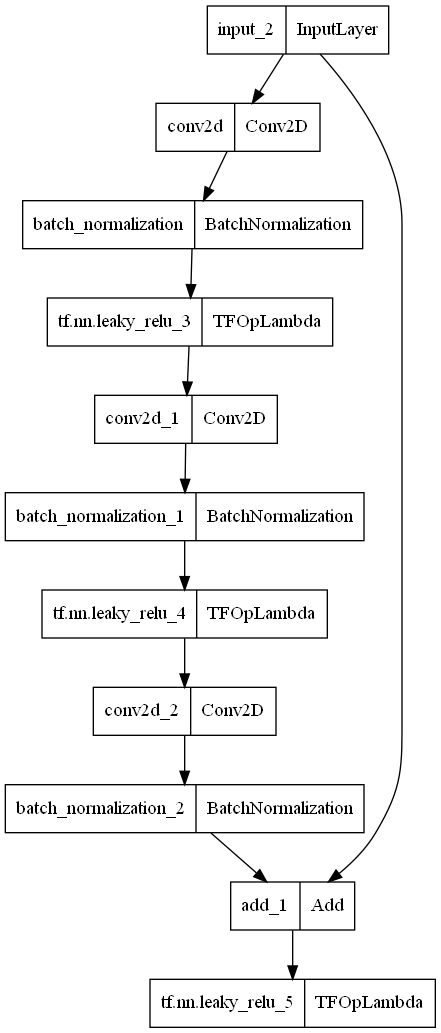

In [8]:
tf.keras.utils.plot_model(identical_block.build_model())

## b) Convolutional residual block
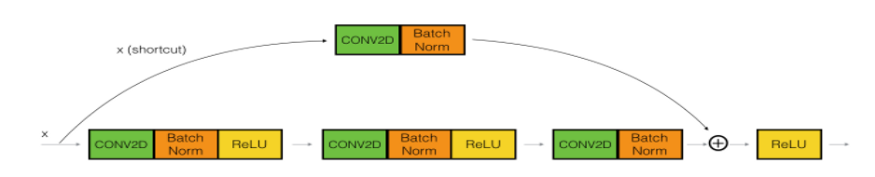

In this type of residual block, the skip-connection consists of a convolutional layer to resize the output of the shortcut path to be of the same dimension as that of the main path. The layer can also make use of different filter sizes, including 1×1, padding, and strides to control the dimension of the output volume.

In [9]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters, strides=(1, 1)):
        f1, f2 = filters
        super(ConvBlock, self).__init__()
        # layer 1 path 1
        self.Conv1 = tf.keras.layers.Conv2D(
            filters=f1,
            kernel_size=(1, 1),
            strides=strides,
            use_bias=False,
            padding="valid",
        )
        self.BN1 = tf.keras.layers.BatchNormalization()
        # layer 2 path 1
        self.Conv2 = tf.keras.layers.Conv2D(
            filters=f1, kernel_size=(3, 3), use_bias=False, padding="same"
        )
        self.BN2 = tf.keras.layers.BatchNormalization()
        # layer 3 path 1
        self.Conv3 = tf.keras.layers.Conv2D(
            filters=f2, kernel_size=(1, 1), use_bias=False, padding="valid"
        )
        self.BN3 = tf.keras.layers.BatchNormalization()

        # layer 1 path 2
        self.Conv4 = tf.keras.layers.Conv2D(
            filters=f2,
            kernel_size=(1, 1),
            strides=strides,
            use_bias=False,
            padding="valid",
        )
        self.BN4 = tf.keras.layers.BatchNormalization()

    def call(self, x):
        x_skip = x
        x_skip = self.Conv4(x_skip)
        x_skip = self.BN4(x_skip)
        # layer 1

        Conv1 = self.Conv1(x)
        BN1 = self.BN1(Conv1)
        BN1 = tf.nn.leaky_relu(BN1)

        # layer 2

        Conv2 = self.Conv2(BN1)
        BN2 = self.BN2(Conv2)
        BN2 = tf.nn.leaky_relu(BN2)

        # layer 3

        Conv3 = self.Conv3(BN2)
        BN3 = self.BN3(Conv3)

        # add the output of layer 3 with the input

        add = tf.keras.layers.Add()([BN3, x_skip])

        add = tf.nn.leaky_relu(add)

        return add

    def build_model(self, shape=(32, 32, 3)):
        inputs = tf.keras.layers.Input(shape=shape)
        return tf.keras.Model(inputs=[inputs], outputs=[self.call(inputs)])


conv_block = ConvBlock(filters=[64, 128], strides=(2, 2))
conv_block.build_model().summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 64)   192         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 16, 16, 64)  256         ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 tf.nn.leaky_relu_6 (TFOpLambda  (None, 16, 16, 64)  0           ['batch_normalization_3[0][

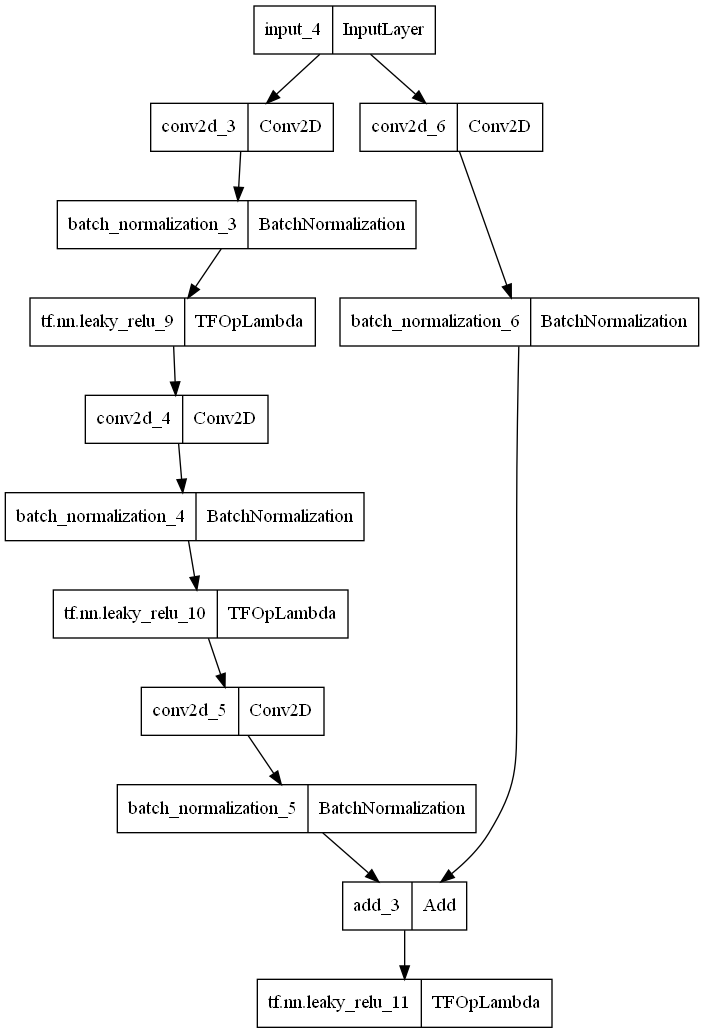

In [10]:
tf.keras.utils.plot_model(conv_block.build_model())

## building  the ResNet model 

The only pooling layers are placed at the very beginning and, before the dense connection at the end of the architecture. To change dimension elsewhere, 1×1 convolution is used as described in the previous section. For the number of filters and other parameters, I followed the Keras example. Now it is time to code. First, we define the simplest identity block where dimension of the input doesn’t change but only the depth, below is the code block

In [11]:
class ResNet(tf.keras.models.Model):
    def __init__(self):
        super(ResNet, self).__init__()

        # block 1
        self.input_conv = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=(5, 5),
            strides=(1, 1),
            use_bias=False,
            padding="same",
        )

        self.BN1 = tf.keras.layers.BatchNormalization()
        self.MaxPool = tf.keras.layers.MaxPool2D()
        # block 2
        self.identical_block_1 = IdenticalBlock(filters=[64, 32])
        # block 3
        self.identical_block_2 = IdenticalBlock(filters=[64, 32])
        # block 4
        self.conv_block_3 = ConvBlock(filters=[128, 64], strides=(2, 2))
        # block 5
        self.identical_block_4 = IdenticalBlock(filters=[128, 64])
        # block 6
        self.identical_block_5 = IdenticalBlock(filters=[128, 64])
        # block 7
        self.conv_block_6 = ConvBlock(filters=[256, 128], strides=(2, 2))
        # MPL block

        self.D1 = tf.keras.layers.Dense(units=256, use_bias=False)
        self.BN2 = tf.keras.layers.BatchNormalization()
        self.OUT = tf.keras.layers.Dense(units=10)

    def call(self, inputs):
        x = inputs
        x = self.input_conv(x)
        x = self.BN1(x)
        x = tf.nn.leaky_relu(x)
        x = self.MaxPool(x)
        x = self.identical_block_1(x)
        x = self.identical_block_2(x)
        x = self.conv_block_3(x)
        x = self.identical_block_4(x)
        x = self.identical_block_5(x)
        x = self.conv_block_6(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.D1(x)
        x = self.BN2(x)
        x = tf.nn.leaky_relu(x)
        output = tf.nn.softmax(self.OUT(x))

        return output

    def build_model(self, shape=(32, 32, 3)):
        inputs = tf.keras.layers.Input(shape=shape)
        return tf.keras.Model(inputs=[inputs], outputs=[self.call(inputs)])

In [12]:
model = ResNet()
model.build_model().summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        2400      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 tf.nn.leaky_relu_12 (TFOpLa  (None, 32, 32, 32)       0         
 mbda)                                                           
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                           

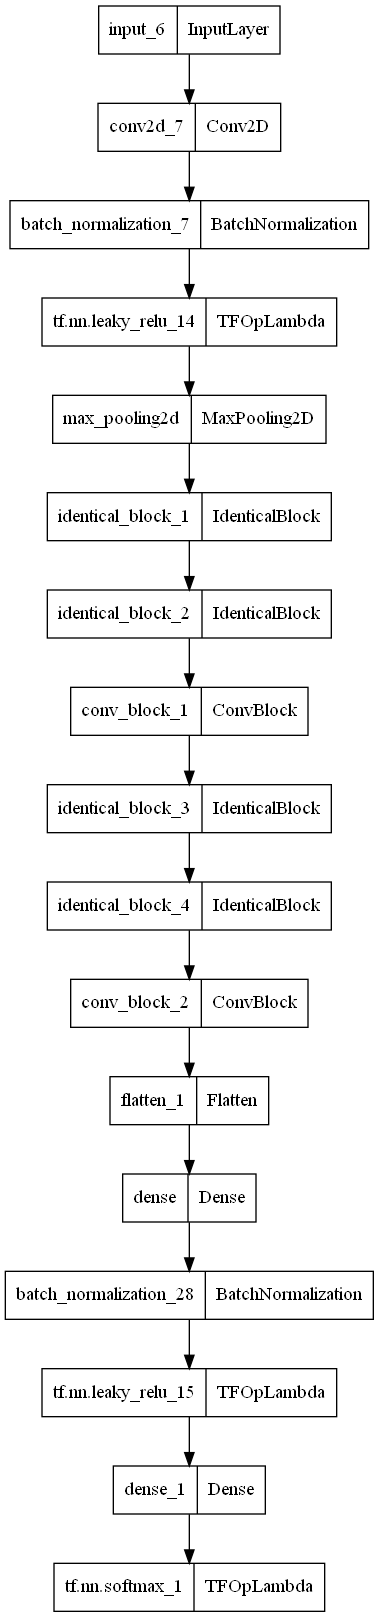

In [13]:
tf.keras.utils.plot_model(model.build_model())

## train the model with the BN layers

In [14]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1563/1563 [==============================] - 49s 19ms/step - loss: 1.3001 - accuracy: 0.5361 - val_loss: 1.2293 - val_accuracy: 0.5723
Epoch 2/5
1563/1563 [==============================] - 35s 22ms/step - loss: 0.9200 - accuracy: 0.6740 - val_loss: 1.1072 - val_accuracy: 0.6112
Epoch 3/5
1563/1563 [==============================] - 30s 19ms/step - loss: 0.7651 - accuracy: 0.7338 - val_loss: 1.2749 - val_accuracy: 0.5786
Epoch 4/5
1563/1563 [==============================] - 28s 18ms/step - loss: 0.6554 - accuracy: 0.7688 - val_loss: 1.4103 - val_accuracy: 0.5778
Epoch 5/5
1563/1563 [==============================] - 31s 20ms/step - loss: 0.5644 - accuracy: 0.8023 - val_loss: 1.1077 - val_accuracy: 0.6599


**Note :** you can notice the difference in the traing time  between the model that useing the BN layers and the model without uisng it.

we are reciting the val loss of 1 a rely in the model that using BN layers

## Plot Training History

In [15]:
train_history = pd.DataFrame(model.history.history)
train_history

,loss,accuracy,val_loss,val_accuracy
0,1.300148,0.53610,1.229290,0.5723
1,0.920036,0.67402,1.107154,0.6112
2,0.765144,0.73376,1.274925,0.5786
3,0.655417,0.76876,1.410322,0.5778
4,0.564439,0.80232,1.107676,0.6599


<AxesSubplot:>

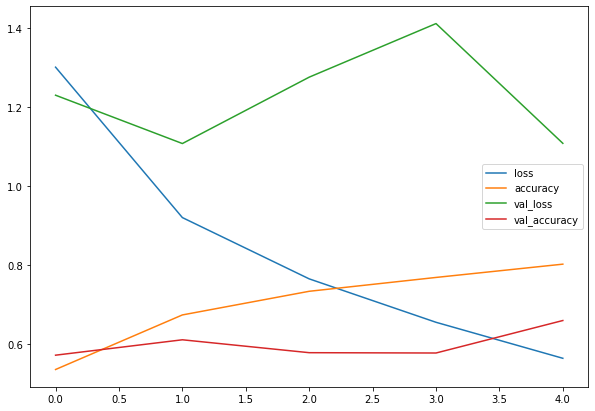

In [16]:
train_history.plot(figsize=(10, 7))